<a href='https://www.latos.ai'> <img src='../logo_latos.jpeg' style="width: 200px;" align="right"/></a>
*Esse notebook faz parte do curso de [Python e Ciência de Dados para a Indústria](https://www.latos.ai/academy/python-e-ciencia-de-dados) da [Latos Academy](https://www.latos.ai).*

Latos© copyright 2022. All Rights Reserved.

# Aprendizado de máquina na indústria - Detecção da oscilação em malhas de controle


## Descrição do problema

Oscilações atingem entre 30% e 41% das malhas de controle em indústrias de processos. Eliminar as oscilações é de grande interesse para essas indústrias, já que resulta em redução na variabilidade. Isso permite que o processo opere mais próximo das condições ótimas, aumentando sua eficiência e, consequentemente, sua rentabilidade.

O primeiro passo para eliminar a oscilação é a sua detecção. Essa tarefa pode ser realizada por inspeção visual das séries temporais provenientes das malhas de controle. Essa abordagem é simples, mas inviável para a detecção em uma planta inteira, já que essa contém entre 500 e 5000 malhas de controle. Assim, a inspeção visual consome recursos humanos excessivos e limita a investigação a apenas algumas malhas da planta. Para superar esse problema, a detecção automática da oscilação é necessária.


Técnicas tradicionais de detecção da oscilação tentam descrever na forma de algoritmos os critérios utilizados por inspeção visual. Esse tipo de abordagem tem boa acurácia para a detecção em séries temporais com comportamento uniforme. Dados industriais, por outro lado, apresentam padrões bastante distintos caracterizados pelos diferentes níveis de ruído de processo, distúrbios, frequências e amplitudes de oscilação, tamanho da janela de análise e tempo de amostragem. Dessa forma, para um algoritmo baseado em regras ter boa acurácia para casos gerais, seria necessário que todas essas influências fossem incorporadas ao algoritmo, o que o tornaria complexo e extenso.

Aqui, tentaremos desenvolver um método baseado em aprendizado de máquina.


### Demais informações

* a presente aplicação fez parte da tese de doutorado do Prof. Jônathan.
* a técnica foi publicada [neste artigo](https://pubs.acs.org/doi/abs/10.1021/acs.iecr.9b01456)
* a base de dados completa pode ser baixada [neste link](https://www.ufrgs.br/gimscop/repository/siso-viewer/datasets/)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import os
import pickle
from datetime import datetime
import pandas as pd
from pathlib import Path
import datetime as dt
from sklearn import metrics

my_figsize = (15, 8)

## Dados para treinamento

Para essa técnica utilizaremos dados artificiais para o treinamento.

A utilização de dados industriais reais para o treinamento geraria um modelo mais representativo, mas esses dados:
* São dificilmente disponibilizados pelas indústrias por questões de confidencialidade. 
* Se disponibilizados, a quantidade geralmente não é suficiente para treinar o modelo. 
* Se suficiente, os dados ainda precisão ser rotulados, o que é uma tarefa demorada e cuja rotulação depende da interpretação dos rotuladores. 
* Se rotulados, ainda assim não existe garantia que esses dados cubram todos os distintos comportamentos encontrados na indústria. 

Dessa forma, dados artificiais são adequados, pois tanto a quantidade quanto a adição dos distintos comportamentos e a rotulação podem ser controladas. 

Para a técnica, foram gerados 100000 exemplos para treinamento do modelo e 10000 para teste. Aqui utilizaremos uma amostragem menor de 10000 dados para treinamento e teste de modo a acelerar as análises.

Os dados são agrupados em 3 classes:
* 0 - sem oscilação
* 1 - oscilação regular
* 2 - oscilação irregular

In [2]:
root_dir = Path.cwd().parents[1]
data_dir = root_dir / 'data'

X, info = pickle.load(open(data_dir / 'oscillation.p', 'rb'))

## Visualização dos dados


{'osc': 1, 'length': 2795, 'per': 59.94866516606319, 'nper': 46.62322325705833, 'waveform': 'tri', 'smooth': 0.06470311470755188, 'dist': 4.657913280456103, 'noise': 0.08520717938310868, 'freq_cg': 1.0932122622391836, 'fact': 0.17564032674270608, 'detect': 1}


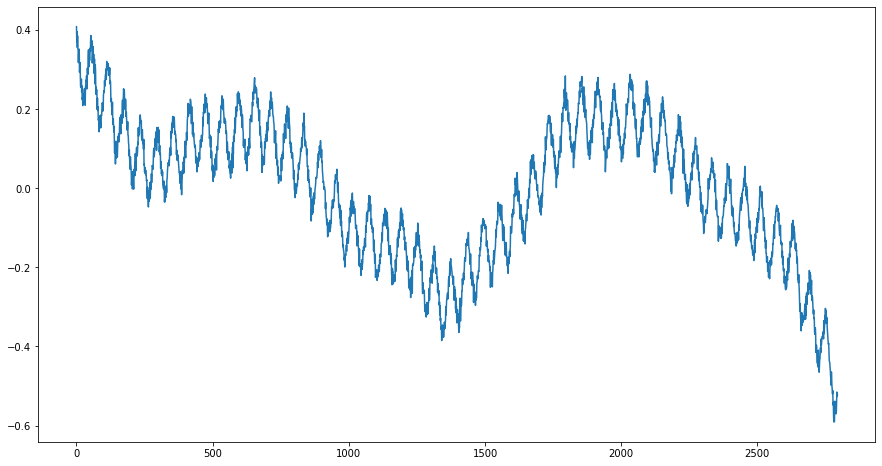

In [3]:
n_data = 1

print(info[n_data])

plt.figure(figsize=my_figsize)
plt.plot(X[n_data])
plt.show()

## Pré-processamento dos dados

In [4]:
def normalization(X):
    '''
    Função para a normalização dos dados para média zero e aplitude igual a 1.
    O fator utilizado para a normatização é salvo para compensar a amplitude 
    quantificada posteriormente.
    '''
    def unit_zmean(x):
        fact = 1 / (max(x) - min(x))
        x_pre = (x - np.mean(x)) * fact
        return x_pre, fact

    X_pre = []
    factor = []

    # Apply
    for i in range(len(X)):
        x = X[i]
        x_pre, fact = unit_zmean(x)

        X_pre.append(x_pre)
        factor.append(fact)

    return X_pre, factor


def dft(X):
    '''
    Transformação para o domínio da frequência das séries temporais normalizadas
    '''
    def dft_each(x):
        return abs(np.fft.fft(x, 2**13))[:int((2**13)/2)+1]    

    return np.asarray([dft_each(x) for x in X])

In [5]:
X_freq = dft(X)

{'osc': 0, 'length': 2055, 'per': 193.21721839004434, 'nper': 10.635698086966588, 'waveform': 'squ', 'smooth': 0.0034721181559591767, 'dist': 1.6773904925487022, 'noise': 0.06787191326792968, 'freq_cg': 0.5417964818924841, 'fact': 0.49540455224178526, 'detect': 0}


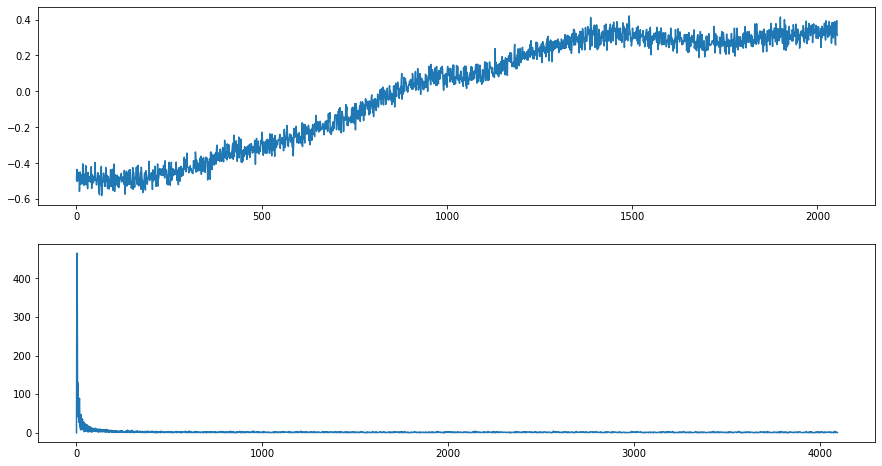

In [6]:
n_data = 0

print(info[n_data])

plt.figure(figsize=my_figsize)
plt.subplot(211)
plt.plot(X[n_data])

plt.subplot(212)
plt.plot(X_freq[n_data])
plt.show()

In [7]:
# y = [i['osc'] for i in info]

y = []
for i in info:
    y.append(i['osc'])

y[:20]

[0, 1, 1, 0, 2, 2, 2, 0, 0, 2, 2, 2, 1, 1, 2, 1, 1, 1, 0, 1]

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_freq, y, test_size=0.1)

## Treinamento de modelo de classificação

In [9]:
from sklearn import tree

mod = tree.DecisionTreeClassifier(max_depth=6)
mod.fit(X_train, y_train)

prediction = mod.predict(X_test)
metrics.accuracy_score(prediction, y_test)

0.677

In [10]:
from sklearn.ensemble import RandomForestClassifier

mod = RandomForestClassifier(n_estimators=50, max_depth=5)
mod.fit(X_test, y_test)

prediction = mod.predict(X_test)
metrics.accuracy_score(prediction, y_test)

0.856

## Como fiz para chegar nos 97% de acurácia?

Existem várias técnicas de aprendizado de máquina com vários parâmetros (hiperparâmetros). Como escolher o conjunto que retorna a melhor acurácia?

Veja que esse é um problema de otimização. Para resolvê-los, podemos utilizar tentativa e erro. Porém, essa abordagem pode ser bastante demorada, já que o número de treinamento pode chegar nos milhares.

Como você já deve imaginar, existem metodologias e implementações que trabalham com isso. Podemos seguir a documentação do [Scikitlearn](https://scikit-learn.org/stable/modules/grid_search.html) novamente para trabalhar com isso.


Além da seleção dos hiperparâmetros, utilizei 100000 exemplos para o meu modelo final, o que aumentou a acurácia sem que o modelo sofresse com overfitting.

Abaixo, o teste com o meu modelo final.

In [11]:
# O Keras e o TensorFlow não estão instalados no nosso ambiente virtual.
# Dessa forma, aceleramos as instalações no início do curso.
# Essas bibliotecas são necessárias apenas para rodar os resultados das próximas células.
# Você pode ignorar essa instalação e acompanhar os resultados pelo vídeo (recomendado) 
# ou instalar # as bibliotecas utilizando os comandos "pip install tensorflow" e "pip install keras"
# dentro do ambiente virtual do curso.

import keras
from keras.models import load_model

od = load_model(root_dir / 'models/oscillation_model.kr')
y_prob = od.predict(X_test)

2022-01-26 10:28:00.499922: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-26 10:28:00.499967: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-01-26 10:28:02.915166: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-26 10:28:02.915216: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jonat-Inspiron-7460): /proc/driver/nvidia/version does not exist
2022-01-26 10:28:02.915977: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations: 

In [12]:
y_prob[:4]

array([[9.4665903e-01, 3.2187477e-02, 2.1153521e-02],
       [9.1993657e-04, 4.1916752e-03, 9.9488837e-01],
       [7.8952042e-03, 9.8401350e-01, 8.0912597e-03],
       [8.9974556e-04, 4.3724775e-03, 9.9472779e-01]], dtype=float32)

In [13]:
prediction = np.argmax(y_prob, axis=1)
metrics.accuracy_score(prediction, y_test)

0.967

Notou como a execução é rápida após o treinamento? 
Isso é porque as operações que o modelo executa são basicamente de multiplicação e soma matricial.

## Aplicação para dados reais

Agora que temos nosso modelo treinado, vamos aplicar aos dados industriais que já estavamos trabalhando. Vamos testar para duas malhas: LIC42/PV e LIC43/PV. 

In [14]:
data = pd.HDFStore(data_dir / 'raw.h5', mode='r')

In [15]:
loops = ['/LIC42/PV', '/LIC43/PV']
pv_values = [data[l]['Values'] for l in loops]

# reamostrar e interpolar NaN
pv_resampled = [pv.resample('1min').mean().interpolate('linear') for pv in pv_values]
pv_resampled[0].head()

Time
2017-10-06 12:00:00    0.120873
2017-10-06 12:01:00    0.109447
2017-10-06 12:02:00    0.094416
2017-10-06 12:03:00    0.098185
2017-10-06 12:04:00    0.081106
Freq: T, Name: Values, dtype: float64

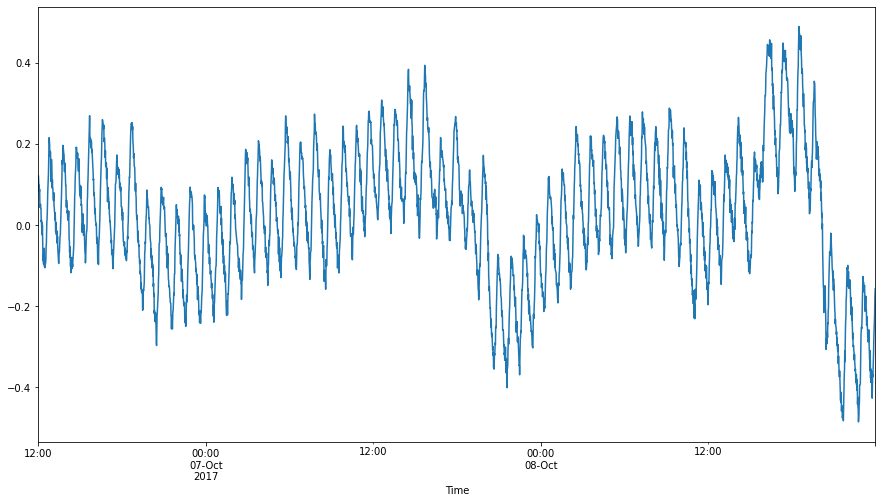

In [16]:
plt.figure(figsize=my_figsize)
pv_resampled[0].plot()
plt.show()

Como vemos, existe oscilação nessa série temporal, que é bem irregular. Então, por inspeção visual, esperamos resultado "2" para esse exemplo.

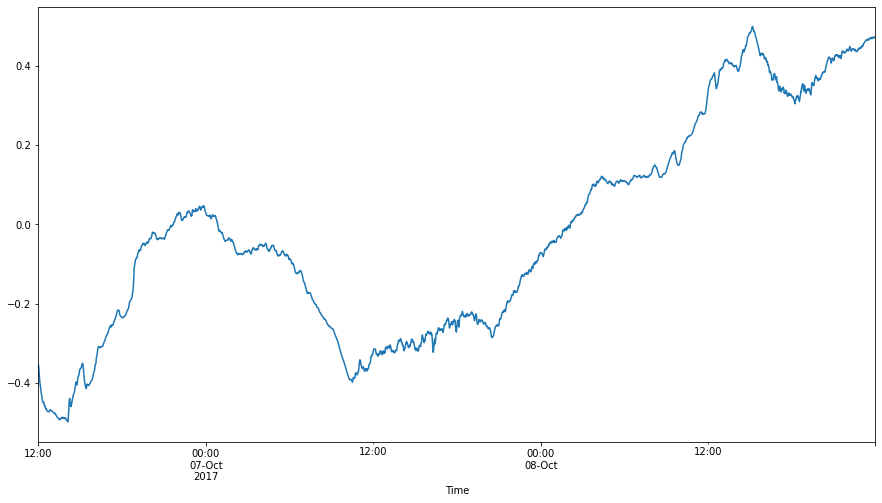

In [17]:
plt.figure(figsize=my_figsize)
pv_resampled[1].plot()
plt.show()

Como vemos, parece não exisitir oscilação para a série temporal. Então, por inspeção visual, esperamos resultado "0" para esse exemplo.

In [18]:
# Processamento
norm, _ = normalization(pv_resampled)
X = dft(norm)

y_prob = od.predict(X)
y_pred = np.argmax(y_prob, axis=1)

print(y_pred)

[2 0]


## Feature extraction

**Hoje, provavelmente eu não seguiria a mesma abordagem.**

Quando desenvolvi o método, testei vários modos de evitar o uso direto das sérires temporais, o que obteve melhores resultados foi o baseado no domínio da frequência.


Hoje, tentaria utilizar feature extraction e selection para gerar as entradas do modelo através da biblioteca "tsfresh¨